In [2590]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2591]:
# Simulation :
m_MC = 100 # Number of simulations
T = 50 # Time horizon in years
N = 50 # Number of time steps (daily frequency)
dt = T / N # Time step
initial_population = 10000  # Initial population size (number of contracts at t=0)


# Fund / Premium :
F0 = 100000 # Initial value of the fund / Premium Invested
sigma_equity = 0.20 # Volatility for equity
sigma_property = 0.10 # Volatility for property
PR_weight = 0.2 # Weight of PR in the portfolio
EQ_weight = 0.8 # Weight of EQ in the portfolio

# Liabilities :
rd_rate = 0.022
comm = 0.014
inflation_rate = 0.02
lapse_rate = 0.15  # Annual lapse rate
cst_cost = 50 # Constant unitary cost

In [ ]:
def simulate_gbm_vec(F0, r, sigma, dt, N, z):
    # Generate N samples from a GBM with risk-free rate r and volatility sigma
    # r and sigma are assumed to be annualized
    # dt is the time step
    # S0 is the initial value of the process
    S = np.zeros((m_MC, N))
    S[:, 0] = np.full(m_MC, F0)
    for t in range(1, N):
        # Update the stock price for all iterations simultaneously
        S[:, t] = S[:, t - 1] * np.exp((r[t] - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z[:, t])
    return S

## LIABILITIES :

In [ ]:
import LapseQ1 as LQ1
import DeathQ1 as DQ1
import COMMQ1 as CQ1
import ExpensesQ1 as EQ1
import MASSQ1 as MQ1

### No stress :

In [ ]:
def Base_Case(N, F0, sigma_equity, sigma_property, dt, m_MC, EQ_weight, PR_weight, lapse_rate, rd_rate, COMM, cst_cost, inflation_rate):
    """
    Generation of the random standard-normal vector :
    """
    # Generate m_MC samples of random normal variables
    z = np.random.normal(size=(m_MC, N))

    """
    Expenses :
    """
    # Generate the 50€ vector following the inflation :
    Expenses = np.zeros(N)
    Expenses[1:] = [cst_cost * (1 + inflation_rate) ** i for i in range(1,N)]
    
    """
    RFR :
    """
    # Read Excel file
    df = pd.read_excel('EIOPA_RFR_20240331_Term_Structures.xlsx', "RFR_spot_no_VA", usecols="C", )
    df = df[9:]
    df = df.rename(columns={'Unnamed: 18': 'EIOPA EU without VA, MAR'})
    rt = np.array(df).T
    rt = np.array(rt, np.float64)
    rt = rt[0, :N] # Time-varying risk-free rate

    """
    Simulation of the fund :
    """
    # Simulate equity and property paths
    EQt = simulate_gbm_vec(F0, rt, sigma_equity, dt, N, z)
    PRt = simulate_gbm_vec(F0, rt, sigma_property, dt, N, z)
    # Calculate the fund value at each time step
    fund_value = EQ_weight * EQt + PR_weight * PRt
    F = np.squeeze(fund_value)

    print(str(np.quantile(F, 0.995)))

    """
    Compute the discount factors :
    """
    EIOPA_yield_curve = pd.DataFrame()
    EIOPA_yield_curve['Years'] = np.arange(0, 51, 1)
    EIOPA_yield_curve['EIOPA EU without VA, MARCH 2024'] = np.insert(rt, 0, 0)  # EIOPA RFR spot rate no VA, with 0 at year = 0 so that discount = 1
    EIOPA_yield_curve['Discount Factors'] = 1 / (1 + EIOPA_yield_curve['EIOPA EU without VA, MARCH 2024']) ** EIOPA_yield_curve['Years']

    """
    Life table :
    """
    df_LT = pd.read_excel("LT_M_only.xlsx", skiprows=[0], index_col=0)
    Life_table = pd.DataFrame()
    Life_table['Age'] = np.arange(60, 120, 1)
    Life_table['Death probability qx'] = np.array(df_LT['Probability of death (per thousand)  qx'][60:120]) / 1000
    Life_table['Cumulative survival probability px'] = (1 - Life_table['Death probability qx']).cumprod()
    
    """
    Get the needed data :
    """
    px_cumul = Life_table["Cumulative survival probability px"][:50]
    discount_factors = EIOPA_yield_curve["Discount Factors"][:-1]
    qx = Life_table["Death probability qx"]

    """
    Compute the BEL :
    """
    MC_liab = LQ1.MC_lapse_liabilities_VaR(m_MC, F, discount_factors, px_cumul, lapse_rate, rd_rate)
    d_MC_liab = DQ1.MC_death_liabilities_VaR(m_MC, F, discount_factors, px_cumul, lapse_rate, rd_rate, qx)
    L_n_D_COMM_liab = CQ1.L_and_D_COMM_Liabilities_VaR(m_MC, COMM, N, lapse_rate, px_cumul, discount_factors, qx, F)
    Exp_liab = EQ1.Expenses_liabilities(Expenses, discount_factors, lapse_rate, px_cumul, N).sum()
    Exp_liab = np.full_like(MC_liab, Exp_liab)

    """
    Compute the total liabilities :
    """
    BEL = MC_liab + d_MC_liab + L_n_D_COMM_liab + Exp_liab

    """
    Compute the BOF under IR up stress :
    """
    MVA = F[0][0]
    BOF = MVA - BEL

    """
    Compute the Delta_BOF under IR up stress :
    """
    D_BOF = BOF - BOF

    """
    Compute the SCR under IR up stress using VaR(99.5%) :
    """
    SCR = np.maximum(0, D_BOF)
    SCR = np.quantile(SCR, 0.995) # VaR at 99.5%
    return MVA, BEL, BOF, D_BOF, SCR, z

In [ ]:
MVA_base, BEL_base, base_BOF, D_BOF_base, SCR_base, z = Base_Case(N, F0, sigma_equity, sigma_property, dt, m_MC, EQ_weight, PR_weight, lapse_rate, rd_rate, comm, cst_cost, inflation_rate)

1645293.5664110975


In [ ]:
z.shape # test de la dimension

(100, 50)

In [ ]:
z[6].std(), z[69].mean() # test que c'est bien normal 0-1

(0.936346848387398, -0.18501801872054927)

### IR up :

In [ ]:
def IR_up_Case(z, base_BOF, N, F0, sigma_equity, sigma_property, dt, m_MC, EQ_weight, PR_weight, lapse_rate, rd_rate, COMM, cst_cost, inflation_rate):
    """
    Expenses :
    """
    # Generate the 50€ vector following the inflation :
    Expenses = np.zeros(N)
    Expenses[1:] = [cst_cost * (1 + inflation_rate) ** i for i in range(1,N)]
    
    """
    RFR :
    """
    # Read Excel file
    df_up = pd.read_excel('EIOPA_RFR_20240331_Term_Structures.xlsx', "Spot_NO_VA_shock_UP", usecols="C", )
    df_up = df_up[9:]
    df_up = df_up.rename(columns={'Unnamed: 2': 'EIOPA EU without VA, MAR'})
    rt_up = np.array(df_up).T
    rt_up = np.array(rt_up, np.float64)
    rt_up = rt_up[0, :N] # Time-varying risk-free rate

    """
    Simulation of the fund :
    """
    # Simulate equity and property paths
    EQt_rt_up = simulate_gbm_vec(F0, rt_up, sigma_equity, dt, N, z)
    PRt_rt_up = simulate_gbm_vec(F0, rt_up, sigma_property, dt, N, z)
    # Calculate the fund value at each time step
    fund_value_rt_up = EQ_weight * EQt_rt_up + PR_weight * PRt_rt_up
    F_rt_up = np.squeeze(fund_value_rt_up)

    print(str(np.quantile(F_rt_up, 0.995)))

    """
    Compute the discount factors :
    """
    EIOPA_yield_curve = pd.DataFrame()
    EIOPA_yield_curve['Years'] = np.arange(0, 51, 1)
    EIOPA_yield_curve['EIOPA EU without VA, MARCH 2024'] = np.insert(rt_up, 0, 0)  # EIOPA RFR spot rate no VA, with 0 at year = 0 so that discount = 1
    EIOPA_yield_curve['Discount Factors'] = 1 / (1 + EIOPA_yield_curve['EIOPA EU without VA, MARCH 2024']) ** EIOPA_yield_curve['Years']

    """
    Life table :
    """
    df_LT = pd.read_excel("LT_M_only.xlsx", skiprows=[0], index_col=0)
    Life_table = pd.DataFrame()
    Life_table['Age'] = np.arange(60, 120, 1)
    Life_table['Death probability qx'] = np.array(df_LT['Probability of death (per thousand)  qx'][60:120]) / 1000
    Life_table['Cumulative survival probability px'] = (1 - Life_table['Death probability qx']).cumprod()
    
    """
    Get the needed data :
    """
    px_cumul = Life_table["Cumulative survival probability px"][:50]
    discount_factors_up = EIOPA_yield_curve["Discount Factors"][:-1]
    qx = Life_table["Death probability qx"]

    """
    Compute the BEL :
    """
    MC_liab = LQ1.MC_lapse_liabilities_VaR(m_MC, F_rt_up, discount_factors_up, px_cumul, lapse_rate, rd_rate)
    d_MC_liab = DQ1.MC_death_liabilities_VaR(m_MC, F_rt_up, discount_factors_up, px_cumul, lapse_rate, rd_rate, qx)
    L_n_D_COMM_liab = CQ1.L_and_D_COMM_Liabilities_VaR(m_MC, COMM, N, lapse_rate, px_cumul, discount_factors_up, qx, F_rt_up)
    Exp_liab = EQ1.Expenses_liabilities(Expenses, discount_factors_up, lapse_rate, px_cumul, N).sum()
    Exp_liab = np.full_like(MC_liab, Exp_liab)

    """
    Compute the total liabilities :
    """
    BEL = MC_liab + d_MC_liab + L_n_D_COMM_liab + Exp_liab

    """
    Compute the BOF under IR up stress :
    """
    MVA = F_rt_up[0][0]
    BOF = MVA - BEL

    """
    Compute the Delta_BOF under IR up stress :
    """
    D_BOF = base_BOF - BOF

    """
    Compute the SCR under IR up stress using VaR(99.5%) :
    """
    SCR = np.maximum(0, D_BOF)
    SCR = np.quantile(SCR, 0.995) # VaR at 99.5%
    return MVA, BEL, BOF, D_BOF, SCR, z

In [ ]:
MVA_IR_UP, BEL_IR_UP, BOF_IR_UP, D_BOF_IR_UP, SCR_IR_UP, z = IR_up_Case(z, base_BOF, N, F0, sigma_equity, sigma_property, dt, m_MC, EQ_weight, PR_weight, lapse_rate, rd_rate, comm, cst_cost, inflation_rate)

2691321.9943248094


In [ ]:
SCR_IR_UP

4494.540020748217

In [ ]:
z[:4, :4]

array([[-0.937688  , -0.13325063,  0.56075113,  1.09183558],
       [-1.11903364,  0.52796562, -0.38856872, -1.10669069],
       [-0.54131701, -0.26502916, -0.40202849,  1.00118017],
       [ 1.06701496, -0.43967802,  1.03749531,  1.40226271]])

### IR dw :

In [ ]:
def IR_dw_Case(z, base_BOF, N, F0, sigma_equity, sigma_property, dt, m_MC, EQ_weight, PR_weight, lapse_rate, rd_rate, COMM, cst_cost, inflation_rate):
    """
    Expenses :
    """
    # Generate the 50€ vector following the inflation :
    Expenses = np.zeros(N)
    Expenses[1:] = [cst_cost * (1 + inflation_rate) ** i for i in range(1,N)]
    
    """
    RFR :
    """
    # Read Excel file
    df = pd.read_excel('EIOPA_RFR_20240331_Term_Structures.xlsx', "Spot_NO_VA_shock_DOWN", usecols="C", )
    df = df[9:]
    df = df.rename(columns={'Unnamed: 2': 'EIOPA EU without VA, MAR'})
    rt_down = np.array(df).T
    rt_down = np.array(rt_down, np.float64)
    rt_down = rt_down[0, :N] # Time-varying risk-free rate

    """
    Simulation of the fund :
    """
    # Simulate equity and property paths
    EQt_rt_down = simulate_gbm_vec(F0, rt_down, sigma_equity, dt, N, z)
    PRt_rt_down = simulate_gbm_vec(F0, rt_down, sigma_property, dt, N, z)
    # Calculate the fund value at each time step
    fund_value_rt_down = EQ_weight * EQt_rt_down + PR_weight * PRt_rt_down
    F_rt_down = np.squeeze(fund_value_rt_down)

    print(str(np.quantile(F_rt_down, 0.995)))

    """
    Compute the discount factors :
    """
    EIOPA_yield_curve = pd.DataFrame()
    EIOPA_yield_curve['Years'] = np.arange(0, 51, 1)
    EIOPA_yield_curve['EIOPA EU without VA, MARCH 2024'] = np.insert(rt_down, 0, 0)  # EIOPA RFR spot rate no VA, with 0 at year = 0 so that discount = 1
    EIOPA_yield_curve['Discount Factors'] = 1 / (1 + EIOPA_yield_curve['EIOPA EU without VA, MARCH 2024']) ** EIOPA_yield_curve['Years']

    """
    Life table :
    """
    df_LT = pd.read_excel("LT_M_only.xlsx", skiprows=[0], index_col=0)
    Life_table = pd.DataFrame()
    Life_table['Age'] = np.arange(60, 120, 1)
    Life_table['Death probability qx'] = np.array(df_LT['Probability of death (per thousand)  qx'][60:120]) / 1000
    Life_table['Cumulative survival probability px'] = (1 - Life_table['Death probability qx']).cumprod()
    
    """
    Get the needed data :
    """
    px_cumul = Life_table["Cumulative survival probability px"][:50]
    discount_factors_dw = EIOPA_yield_curve["Discount Factors"][:-1]
    qx = Life_table["Death probability qx"]

    """
    Compute the BEL :
    """
    MC_liab = LQ1.MC_lapse_liabilities_VaR(m_MC, F_rt_down, discount_factors_dw, px_cumul, lapse_rate, rd_rate)
    d_MC_liab = DQ1.MC_death_liabilities_VaR(m_MC, F_rt_down, discount_factors_dw, px_cumul, lapse_rate, rd_rate, qx)
    L_n_D_COMM_liab = CQ1.L_and_D_COMM_Liabilities_VaR(m_MC, COMM, N, lapse_rate, px_cumul, discount_factors_dw, qx, F_rt_down)
    Exp_liab = EQ1.Expenses_liabilities(Expenses, discount_factors_dw, lapse_rate, px_cumul, N).sum()
    Exp_liab = np.full_like(MC_liab, Exp_liab)

    """
    Compute the total liabilities :
    """
    BEL = MC_liab + d_MC_liab + L_n_D_COMM_liab + Exp_liab

    """
    Compute the BOF under IR up stress :
    """
    MVA = F_rt_down[0][0]
    BOF = MVA - BEL

    """
    Compute the Delta_BOF under IR up stress :
    """
    D_BOF = base_BOF - BOF

    """
    Compute the SCR under IR up stress using VaR(99.5%) :
    """
    SCR = np.maximum(0, D_BOF)
    SCR = np.quantile(SCR, 0.995) # VaR at 99.5%
    return MVA, BEL, BOF, D_BOF, SCR, z

In [ ]:
MVA_IR_DW, BEL_IR_DW, BOF_IR_DW, D_BOF_IR_DW, SCR_IR_DW, z = IR_dw_Case(z, base_BOF, N, F0, sigma_equity, sigma_property, dt, m_MC, EQ_weight, PR_weight, lapse_rate, rd_rate, comm, cst_cost, inflation_rate)

1147515.706570742


In [ ]:
SCR_IR_DW

154.5013038488313

In [ ]:
z[:4, :4]

array([[-0.937688  , -0.13325063,  0.56075113,  1.09183558],
       [-1.11903364,  0.52796562, -0.38856872, -1.10669069],
       [-0.54131701, -0.26502916, -0.40202849,  1.00118017],
       [ 1.06701496, -0.43967802,  1.03749531,  1.40226271]])

Max between the two SCRs of the IR :

In [ ]:
SCR_IR = max(SCR_IR_DW, SCR_IR_UP)
SCR_IR

4494.540020748217

### EQ :

In [ ]:
def EQ_Case(z, base_BOF, N, F0, sigma_equity, sigma_property, dt, m_MC, EQ_weight, PR_weight, lapse_rate, rd_rate, COMM, cst_cost, inflation_rate):
    """
    Expenses :
    """
    # Generate the 50€ vector following the inflation :
    Expenses = np.zeros(N)
    Expenses[1:] = [cst_cost * (1 + inflation_rate) ** i for i in range(1,N)]
    
    """
    RFR :
    """
    # Read Excel file
    df = pd.read_excel('EIOPA_RFR_20240331_Term_Structures.xlsx', "RFR_spot_no_VA", usecols="C", )
    df = df[9:]
    df = df.rename(columns={'Unnamed: 18': 'EIOPA EU without VA, MAR'})
    rt = np.array(df).T
    rt = np.array(rt, np.float64)
    rt = rt[0, :N] # Time-varying risk-free rate

    """
    Simulation of the fund :
    """
    shock_rate_equity_down = 0.39
    #Equity in down scenario :
    EQt_down = simulate_gbm_vec(F0, rt, sigma_equity, dt, N, z)*(1-shock_rate_equity_down)
    #Property :
    PRt = simulate_gbm_vec(F0, rt, sigma_property, dt, N, z)
    # Calculate the fund value at each time step
    fund_value_eqt_down = EQ_weight * EQt_down + PR_weight * PRt
    F_eqt_down = np.squeeze(fund_value_eqt_down)

    print(str(np.quantile(F_eqt_down, 0.995)))

    """
    Compute the discount factors :
    """
    EIOPA_yield_curve = pd.DataFrame()
    EIOPA_yield_curve['Years'] = np.arange(0, 51, 1)
    EIOPA_yield_curve['EIOPA EU without VA, MARCH 2024'] = np.insert(rt, 0, 0)  # EIOPA RFR spot rate no VA, with 0 at year = 0 so that discount = 1
    EIOPA_yield_curve['Discount Factors'] = 1 / (1 + EIOPA_yield_curve['EIOPA EU without VA, MARCH 2024']) ** EIOPA_yield_curve['Years']

    """
    Life table :
    """
    df_LT = pd.read_excel("LT_M_only.xlsx", skiprows=[0], index_col=0)
    Life_table = pd.DataFrame()
    Life_table['Age'] = np.arange(60, 120, 1)
    Life_table['Death probability qx'] = np.array(df_LT['Probability of death (per thousand)  qx'][60:120]) / 1000
    Life_table['Cumulative survival probability px'] = (1 - Life_table['Death probability qx']).cumprod()
    
    """
    Get the needed data :
    """
    px_cumul = Life_table["Cumulative survival probability px"][:50]
    discount_factors = EIOPA_yield_curve["Discount Factors"][:-1]
    qx = Life_table["Death probability qx"]

    """
    Compute the BEL :
    """
    MC_liab = LQ1.MC_lapse_liabilities_VaR(m_MC, F_eqt_down, discount_factors, px_cumul, lapse_rate, rd_rate)
    d_MC_liab = DQ1.MC_death_liabilities_VaR(m_MC, F_eqt_down, discount_factors, px_cumul, lapse_rate, rd_rate, qx)
    L_n_D_COMM_liab = CQ1.L_and_D_COMM_Liabilities_VaR(m_MC, COMM, N, lapse_rate, px_cumul, discount_factors, qx, F_eqt_down)
    Exp_liab = EQ1.Expenses_liabilities(Expenses, discount_factors, lapse_rate, px_cumul, N).sum()
    Exp_liab = np.full_like(MC_liab, Exp_liab)

    """
    Compute the total liabilities :
    """
    BEL = MC_liab + d_MC_liab + L_n_D_COMM_liab + Exp_liab

    """
    Compute the BOF under IR up stress :
    """
    MVA = F_eqt_down[0][0]
    BOF = MVA - BEL

    """
    Compute the Delta_BOF under IR up stress :
    """
    D_BOF = base_BOF - BOF

    """
    Compute the SCR under IR up stress using VaR(99.5%) :
    """
    SCR = np.maximum(0, D_BOF)
    SCR = np.quantile(SCR, 0.995) # VaR at 99.5%
    return MVA, BEL, BOF, D_BOF, SCR, z

In [ ]:
MVA_EQ, BEL_EQ, BOF_EQ, D_BOF_EQ, SCR_EQ, z = EQ_Case(z, base_BOF, N, F0, sigma_equity, sigma_property, dt, m_MC, EQ_weight, PR_weight, lapse_rate, rd_rate, comm, cst_cost, inflation_rate)

1081524.5755595358


In [ ]:
MVA_EQ

68800.0

In [ ]:
SCR_EQ

15520.31476668948

In [ ]:
z[:4, :4]

array([[-0.937688  , -0.13325063,  0.56075113,  1.09183558],
       [-1.11903364,  0.52796562, -0.38856872, -1.10669069],
       [-0.54131701, -0.26502916, -0.40202849,  1.00118017],
       [ 1.06701496, -0.43967802,  1.03749531,  1.40226271]])

### PR :

In [ ]:
def PR_Case(z, base_BOF, N, F0, sigma_equity, sigma_property, dt, m_MC, EQ_weight, PR_weight, lapse_rate, rd_rate, COMM, cst_cost, inflation_rate):
    """
    Expenses :
    """
    # Generate the 50€ vector following the inflation :
    Expenses = np.zeros(N)
    Expenses[1:] = [cst_cost * (1 + inflation_rate) ** i for i in range(1,N)]
    
    """
    RFR :
    """
    # Read Excel file
    df = pd.read_excel('EIOPA_RFR_20240331_Term_Structures.xlsx', "RFR_spot_no_VA", usecols="C", )
    df = df[9:]
    df = df.rename(columns={'Unnamed: 18': 'EIOPA EU without VA, MAR'})
    rt = np.array(df).T
    rt = np.array(rt, np.float64)
    rt = rt[0, :N] # Time-varying risk-free rate

    """
    Simulation of the fund :
    """
    shock_rate_property_down = 0.25
    #Property in down scenario :
    PRt_down = simulate_gbm_vec(F0, rt, sigma_property, dt, N, z)*(1-shock_rate_property_down)
    #Equity :
    EQt= simulate_gbm_vec(F0, rt, sigma_equity, dt, N, z)
    # Calculate the fund value at each time step
    fund_value_prt_down = EQ_weight * EQt + PR_weight * PRt_down
    F_prt_down = np.squeeze(fund_value_prt_down)

    print(str(np.quantile(F_prt_down, 0.995)))

    """
    Compute the discount factors :
    """
    EIOPA_yield_curve = pd.DataFrame()
    EIOPA_yield_curve['Years'] = np.arange(0, 51, 1)
    EIOPA_yield_curve['EIOPA EU without VA, MARCH 2024'] = np.insert(rt, 0, 0)  # EIOPA RFR spot rate no VA, with 0 at year = 0 so that discount = 1
    EIOPA_yield_curve['Discount Factors'] = 1 / (1 + EIOPA_yield_curve['EIOPA EU without VA, MARCH 2024']) ** EIOPA_yield_curve['Years']

    """
    Life table :
    """
    df_LT = pd.read_excel("LT_M_only.xlsx", skiprows=[0], index_col=0)
    Life_table = pd.DataFrame()
    Life_table['Age'] = np.arange(60, 120, 1)
    Life_table['Death probability qx'] = np.array(df_LT['Probability of death (per thousand)  qx'][60:120]) / 1000
    Life_table['Cumulative survival probability px'] = (1 - Life_table['Death probability qx']).cumprod()
    
    """
    Get the needed data :
    """
    px_cumul = Life_table["Cumulative survival probability px"][:50]
    discount_factors = EIOPA_yield_curve["Discount Factors"][:-1]
    qx = Life_table["Death probability qx"]

    """
    Compute the BEL :
    """
    MC_liab = LQ1.MC_lapse_liabilities_VaR(m_MC, F_prt_down, discount_factors, px_cumul, lapse_rate, rd_rate)
    d_MC_liab = DQ1.MC_death_liabilities_VaR(m_MC, F_prt_down, discount_factors, px_cumul, lapse_rate, rd_rate, qx)
    L_n_D_COMM_liab = CQ1.L_and_D_COMM_Liabilities_VaR(m_MC, COMM, N, lapse_rate, px_cumul, discount_factors, qx, F_prt_down)
    Exp_liab = EQ1.Expenses_liabilities(Expenses, discount_factors, lapse_rate, px_cumul, N).sum()
    Exp_liab = np.full_like(MC_liab, Exp_liab)

    """
    Compute the total liabilities :
    """
    BEL = MC_liab + d_MC_liab + L_n_D_COMM_liab + Exp_liab

    """
    Compute the BOF under IR up stress :
    """
    MVA = F_prt_down[0][0]
    BOF = MVA - BEL

    """
    Compute the Delta_BOF under IR up stress :
    """
    D_BOF = base_BOF - BOF

    """
    Compute the SCR under IR up stress using VaR(99.5%) :
    """
    SCR = np.maximum(0, D_BOF)
    SCR = np.quantile(SCR, 0.995) # VaR at 99.5%
    return MVA, BEL, BOF, D_BOF, SCR, z

In [ ]:
MVA_PR, BEL_PR, BOF_PR, D_BOF_PR, SCR_PR, z = PR_Case(z, base_BOF, N, F0, sigma_equity, sigma_property, dt, m_MC, EQ_weight, PR_weight, lapse_rate, rd_rate, comm, cst_cost, inflation_rate)

1595360.5535593242


In [ ]:
MVA_PR

95000.0

In [ ]:
SCR_PR

1513.5312324464078

In [ ]:
z[:4, :4]

array([[-0.937688  , -0.13325063,  0.56075113,  1.09183558],
       [-1.11903364,  0.52796562, -0.38856872, -1.10669069],
       [-0.54131701, -0.26502916, -0.40202849,  1.00118017],
       [ 1.06701496, -0.43967802,  1.03749531,  1.40226271]])

### Mortality :

In [ ]:
def Mortality_Case(z, base_BOF, N, F0, sigma_equity, sigma_property, dt, m_MC, EQ_weight, PR_weight, lapse_rate, rd_rate, COMM, cst_cost, inflation_rate):
    """
    Expenses :
    """
    # Generate the 50€ vector following the inflation :
    Expenses = np.zeros(N)
    Expenses[1:] = [cst_cost * (1 + inflation_rate) ** i for i in range(1,N)]
    
    """
    RFR :
    """
    # Read Excel file
    df = pd.read_excel('EIOPA_RFR_20240331_Term_Structures.xlsx', "RFR_spot_no_VA", usecols="C", )
    df = df[9:]
    df = df.rename(columns={'Unnamed: 18': 'EIOPA EU without VA, MAR'})
    rt = np.array(df).T
    rt = np.array(rt, np.float64)
    rt = rt[0, :N] # Time-varying risk-free rate

    """
    Simulation of the fund :
    """
    # Simulate equity and property paths
    EQ = simulate_gbm_vec(F0, rt, sigma_equity, dt, N, z)
    PR = simulate_gbm_vec(F0, rt, sigma_property, dt, N, z)
    # Calculate the fund value at each time step
    fund_value = EQ_weight * EQ + PR_weight * PR
    F = np.squeeze(fund_value)

    print(str(F[0][0]))
    print(str(np.quantile(F, 0.995)))

    """
    Compute the discount factors :
    """
    EIOPA_yield_curve = pd.DataFrame()
    EIOPA_yield_curve['Years'] = np.arange(0, 51, 1)
    EIOPA_yield_curve['EIOPA EU without VA, MARCH 2024'] = np.insert(rt, 0, 0)  # EIOPA RFR spot rate no VA, with 0 at year = 0 so that discount = 1
    EIOPA_yield_curve['Discount Factors'] = 1 / (1 + EIOPA_yield_curve['EIOPA EU without VA, MARCH 2024']) ** EIOPA_yield_curve['Years']

    """
    Life table :
    """
    df_LT = pd.read_excel("LT_M_only.xlsx", skiprows=[0], index_col=0)
    Life_table = pd.DataFrame()
    Life_table['Age'] = np.arange(60, 120, 1)
    Life_table['Death probability qx'] = np.array(df_LT['Probability of death (per thousand)  qx'][60:120]) / 1000
    Life_table['Death probability qx'] = Life_table['Death probability qx'] * 1.15 # Mortality shock 
    Life_table['Cumulative survival probability px'] = (1 - Life_table['Death probability qx']).cumprod()
    
    """
    Get the needed data :
    """
    px_cumul = Life_table["Cumulative survival probability px"][:50]
    discount_factors_up = EIOPA_yield_curve["Discount Factors"][:-1]
    qx = Life_table["Death probability qx"]

    """
    Compute the BEL :
    """
    MC_liab = LQ1.MC_lapse_liabilities_VaR(m_MC, F, discount_factors_up, px_cumul, lapse_rate, rd_rate)
    d_MC_liab = DQ1.MC_death_liabilities_VaR(m_MC, F, discount_factors_up, px_cumul, lapse_rate, rd_rate, qx)
    L_n_D_COMM_liab = CQ1.L_and_D_COMM_Liabilities_VaR(m_MC, COMM, N, lapse_rate, px_cumul, discount_factors_up, qx, F)
    Exp_liab = EQ1.Expenses_liabilities(Expenses, discount_factors_up, lapse_rate, px_cumul, N).sum()
    Exp_liab = np.full_like(MC_liab, Exp_liab)

    """
    Compute the total liabilities :
    """
    BEL = MC_liab + d_MC_liab + L_n_D_COMM_liab + Exp_liab

    """
    Compute the BOF under IR up stress :
    """
    MVA = F[0][0]
    BOF = MVA - BEL

    """
    Compute the Delta_BOF under IR up stress :
    """
    D_BOF = base_BOF - BOF

    """
    Compute the SCR under IR up stress using VaR(99.5%) :
    """
    SCR = np.maximum(0, D_BOF)
    SCR = np.quantile(SCR, 0.995) # VaR at 99.5%
    return MVA, BEL, BOF, D_BOF, SCR, z

In [ ]:
MVA_MORT, BEL_MORT, BOF_MORT, D_BOF_MORT, SCR_MORT, z = Mortality_Case(z, base_BOF, N, F0, sigma_equity, sigma_property, dt, m_MC, EQ_weight, PR_weight, lapse_rate, rd_rate, comm, cst_cost, inflation_rate)

100000.0
1645293.5664110975


In [ ]:
SCR_MORT

510.2229941371

In [ ]:
z[:4, :4]

array([[-0.937688  , -0.13325063,  0.56075113,  1.09183558],
       [-1.11903364,  0.52796562, -0.38856872, -1.10669069],
       [-0.54131701, -0.26502916, -0.40202849,  1.00118017],
       [ 1.06701496, -0.43967802,  1.03749531,  1.40226271]])

### Lapse :

#### Lapse up :

In [ ]:
def Lapse_up_Case(z, base_BOF, N, F0, sigma_equity, sigma_property, dt, m_MC, EQ_weight, PR_weight, rd_rate, COMM, cst_cost, inflation_rate):
    lapse_rate_up = 0.225  # Annual lapse rate in up shock scenario
    """
    Expenses :
    """
    # Generate the 50€ vector following the inflation :
    Expenses = np.zeros(N)
    Expenses[1:] = [cst_cost * (1 + inflation_rate) ** i for i in range(1,N)]
    
    """
    RFR :
    """
    # Read Excel file
    df = pd.read_excel('EIOPA_RFR_20240331_Term_Structures.xlsx', "RFR_spot_no_VA", usecols="C", )
    df = df[9:]
    df = df.rename(columns={'Unnamed: 18': 'EIOPA EU without VA, MAR'})
    rt = np.array(df).T
    rt = np.array(rt, np.float64)
    rt = rt[0, :N] # Time-varying risk-free rate

    """
    Simulation of the fund :
    """
    # Simulate equity and property paths
    EQt = simulate_gbm_vec(F0, rt, sigma_equity, dt, N, z)
    PRt = simulate_gbm_vec(F0, rt, sigma_property, dt, N, z)
    # Calculate the fund value at each time step
    fund_value = EQ_weight * EQt + PR_weight * PRt
    F = np.squeeze(fund_value)

    print(str(np.quantile(F, 0.995)))

    """
    Compute the discount factors :
    """
    EIOPA_yield_curve = pd.DataFrame()
    EIOPA_yield_curve['Years'] = np.arange(0, 51, 1)
    EIOPA_yield_curve['EIOPA EU without VA, MARCH 2024'] = np.insert(rt, 0, 0)  # EIOPA RFR spot rate no VA, with 0 at year = 0 so that discount = 1
    EIOPA_yield_curve['Discount Factors'] = 1 / (1 + EIOPA_yield_curve['EIOPA EU without VA, MARCH 2024']) ** EIOPA_yield_curve['Years']

    """
    Life table :
    """
    df_LT = pd.read_excel("LT_M_only.xlsx", skiprows=[0], index_col=0)
    Life_table = pd.DataFrame()
    Life_table['Age'] = np.arange(60, 120, 1)
    Life_table['Death probability qx'] = np.array(df_LT['Probability of death (per thousand)  qx'][60:120]) / 1000
    Life_table['Cumulative survival probability px'] = (1 - Life_table['Death probability qx']).cumprod()
    
    """
    Get the needed data :
    """
    px_cumul = Life_table["Cumulative survival probability px"][:50]
    discount_factors = EIOPA_yield_curve["Discount Factors"][:-1]
    qx = Life_table["Death probability qx"]

    """
    Compute the BEL :
    """
    MC_liab = LQ1.MC_lapse_liabilities_VaR(m_MC, F, discount_factors, px_cumul, lapse_rate_up, rd_rate)
    d_MC_liab = DQ1.MC_death_liabilities_VaR(m_MC, F, discount_factors, px_cumul, lapse_rate_up, rd_rate, qx)
    L_n_D_COMM_liab = CQ1.L_and_D_COMM_Liabilities_VaR(m_MC, COMM, N, lapse_rate_up, px_cumul, discount_factors, qx, F)
    Exp_liab = EQ1.Expenses_liabilities(Expenses, discount_factors, lapse_rate_up, px_cumul, N).sum()
    Exp_liab = np.full_like(MC_liab, Exp_liab)

    """
    Compute the total liabilities :
    """
    BEL = MC_liab + d_MC_liab + L_n_D_COMM_liab + Exp_liab

    """
    Compute the BOF under IR up stress :
    """
    MVA = F[0][0]
    BOF = MVA - BEL

    """
    Compute the Delta_BOF under IR up stress :
    """
    D_BOF = base_BOF - BOF

    """
    Compute the SCR under IR up stress using VaR(99.5%) :
    """
    SCR = np.maximum(0, D_BOF)
    SCR = np.quantile(SCR, 0.995) # VaR at 99.5%
    return MVA, BEL, BOF, D_BOF, SCR, z

In [ ]:
MVA_L_UP, BEL_L_UP, BOF_L_UP, D_BOF_L_UP, SCR_L_UP, z = Lapse_up_Case(z, base_BOF, N, F0, sigma_equity, sigma_property, dt, m_MC, EQ_weight, PR_weight, rd_rate, comm, cst_cost, inflation_rate)

1645293.5664110975


In [ ]:
SCR_L_UP

11403.99771764385

In [ ]:
z[:4, :4]

array([[-0.937688  , -0.13325063,  0.56075113,  1.09183558],
       [-1.11903364,  0.52796562, -0.38856872, -1.10669069],
       [-0.54131701, -0.26502916, -0.40202849,  1.00118017],
       [ 1.06701496, -0.43967802,  1.03749531,  1.40226271]])

#### Lapse down :

In [ ]:
def Lapse_dw_Case(z, base_BOF, N, F0, sigma_equity, sigma_property, dt, m_MC, EQ_weight, PR_weight, rd_rate, COMM, cst_cost, inflation_rate):
    lapse_rate_dw = 0.075  # Annual lapse rate in up shock scenario
    """
    Expenses :
    """
    # Generate the 50€ vector following the inflation :
    Expenses = np.zeros(N)
    Expenses[1:] = [cst_cost * (1 + inflation_rate) ** i for i in range(1,N)]
    
    """
    RFR :
    """
    # Read Excel file
    df = pd.read_excel('EIOPA_RFR_20240331_Term_Structures.xlsx', "RFR_spot_no_VA", usecols="C", )
    df = df[9:]
    df = df.rename(columns={'Unnamed: 18': 'EIOPA EU without VA, MAR'})
    rt = np.array(df).T
    rt = np.array(rt, np.float64)
    rt = rt[0, :N] # Time-varying risk-free rate

    """
    Simulation of the fund :
    """
    # Simulate equity and property paths
    EQt = simulate_gbm_vec(F0, rt, sigma_equity, dt, N, z)
    PRt = simulate_gbm_vec(F0, rt, sigma_property, dt, N, z)
    # Calculate the fund value at each time step
    fund_value = EQ_weight * EQt + PR_weight * PRt
    F = np.squeeze(fund_value)

    print(str(np.quantile(F, 0.995)))

    """
    Compute the discount factors :
    """
    EIOPA_yield_curve = pd.DataFrame()
    EIOPA_yield_curve['Years'] = np.arange(0, 51, 1)
    EIOPA_yield_curve['EIOPA EU without VA, MARCH 2024'] = np.insert(rt, 0, 0)  # EIOPA RFR spot rate no VA, with 0 at year = 0 so that discount = 1
    EIOPA_yield_curve['Discount Factors'] = 1 / (1 + EIOPA_yield_curve['EIOPA EU without VA, MARCH 2024']) ** EIOPA_yield_curve['Years']

    """
    Life table :
    """
    df_LT = pd.read_excel("LT_M_only.xlsx", skiprows=[0], index_col=0)
    Life_table = pd.DataFrame()
    Life_table['Age'] = np.arange(60, 120, 1)
    Life_table['Death probability qx'] = np.array(df_LT['Probability of death (per thousand)  qx'][60:120]) / 1000
    Life_table['Cumulative survival probability px'] = (1 - Life_table['Death probability qx']).cumprod()
    
    """
    Get the needed data :
    """
    px_cumul = Life_table["Cumulative survival probability px"][:50]
    discount_factors = EIOPA_yield_curve["Discount Factors"][:-1]
    qx = Life_table["Death probability qx"]

    """
    Compute the BEL :
    """
    MC_liab = LQ1.MC_lapse_liabilities_VaR(m_MC, F, discount_factors, px_cumul, lapse_rate_dw, rd_rate)
    lapse_rate_dw = 0.15
    d_MC_liab = DQ1.MC_death_liabilities_VaR(m_MC, F, discount_factors, px_cumul, lapse_rate_dw, rd_rate, qx)
    L_n_D_COMM_liab = CQ1.L_and_D_COMM_Liabilities_VaR(m_MC, COMM, N, lapse_rate_dw, px_cumul, discount_factors, qx, F)
    Exp_liab = EQ1.Expenses_liabilities(Expenses, discount_factors, lapse_rate_dw, px_cumul, N).sum()
    Exp_liab = np.full_like(MC_liab, Exp_liab)

    """
    Compute the total liabilities :
    """
    BEL = MC_liab + d_MC_liab + L_n_D_COMM_liab + Exp_liab
    
    """
    Compute the BOF under IR up stress :
    """
    MVA = F[0][0]
    BOF = MVA - BEL

    """
    Compute the Delta_BOF under IR up stress :
    """
    D_BOF = base_BOF - BOF

    """
    Compute the SCR under IR up stress using VaR(99.5%) :
    """
    SCR = np.maximum(0, D_BOF)
    SCR = np.quantile(SCR, 0.995) # VaR at 99.5%
    return MVA, BEL, BOF, D_BOF, SCR, z

In [ ]:
MVA_L_DW, BEL_L_DW, BOF_L_DW, D_BOF_L_DW, SCR_L_DW, z = Lapse_dw_Case(z, base_BOF, N, F0, sigma_equity, sigma_property, dt, m_MC, EQ_weight, PR_weight, rd_rate, comm, cst_cost, inflation_rate)

1645293.5664110975


In [ ]:
SCR_L_DW # PROBLEME !

17547.610056112768

In [ ]:
z[:4, :4]

array([[-0.937688  , -0.13325063,  0.56075113,  1.09183558],
       [-1.11903364,  0.52796562, -0.38856872, -1.10669069],
       [-0.54131701, -0.26502916, -0.40202849,  1.00118017],
       [ 1.06701496, -0.43967802,  1.03749531,  1.40226271]])

#### Lapse MASS :

In [ ]:
import numpy as np
import DeathQ1 as DQ1
import COMMQ1 as CQ1
import LapseQ1 as LQ1

def lapse_proba(px_cumul, lapse_rate, lapse_MASS):
    """
    Calculate the lapse probability for each period based on the cumulative survival probability and lapse rate.

    Parameters:
    px_cumul (array-like): Array of cumulative survival probabilities.
    lapse_rate (float): Lapse rate for the insurance policy.

    Returns:
    array-like: Array of lapse probabilities for each period.
    """
    # lapse_p = np.array([px_cumul[i - 1] * (1 - lapse_rate) ** i * lapse_rate for i in range(len(px_cumul))])
    lapse_p = np.zeros(px_cumul.shape)

    for i in range(1, len(px_cumul)):
        lapse_p[i] = px_cumul[i - 1] * (1 - lapse_rate) ** (i - 1) * lapse_rate
    return lapse_p * (1 - lapse_MASS) * (1 / (1 - lapse_rate)) * lapse_rate

def death_proba(px_cumul, lapse_rate, qx, lapse_MASS):
    """
    """
    death_p = np.zeros(px_cumul.shape)
    for k in range(1, len(px_cumul)):
        if k == 1:
            death_p[k] = 1 * (1 - lapse_rate) ** (k - 1) * qx[k - 1]
        else:
            death_p[k] = px_cumul[k - 2] * (1 - lapse_rate) ** (k - 1) * qx[k - 1]
    return death_p * (1 - lapse_MASS) * (1 / (1 - lapse_rate))

def lapse_what_do_you_get(Ft, discount_factors):
    """
    Calculate the discounted (present) value of future cash flows based on the discount factors and what you get when you lapse.

    Parameters:
    Ft (array-like): Array of future cash flows.
    discount_factors (array-like): Array of discount factors.

    Returns:
    array-like: Array of present values of future cash flows.
    """
    DPV = (Ft - 20) * discount_factors
    DPV[0] = 0
    return DPV

def MASS_lapse_liabilities(RD, lapse_proba, lapse_what_do_you_get):
    """
    Calculate the lapse liabilities i.e. the net present value of future cash flows that will be paid to the policyholders who lapse.
    i.e. the expected value of the discounted cash flows that will be paid to the policyholders who lapse.

    Returns:
    array-like: Array of lapse liabilities.
    """
    return (1 - RD) * lapse_proba * lapse_what_do_you_get

def MASS_LL_VaR(m_MC, F, discount_factors, px_cumul, lapse_rate, rd_rate, lapse_MASS):
    # Calculate lapse probabilities
    lapse_p = lapse_proba(px_cumul, lapse_rate, lapse_MASS)
    lapse_array = np.zeros(m_MC)
    for m in range(m_MC):
        # Calculate what you get when you lapse
        lapse_what_you_get = lapse_what_do_you_get(F[m], discount_factors)
        # Calculate lapse liabilities
        lapse_liab = LQ1.lapse_liabilities(rd_rate, lapse_p, lapse_what_you_get)
        lapse_array[m] = lapse_liab.sum() # Total lapse liabilities for each scenario
    return lapse_array

def MASS_L_and_D_COMM_L_VaR(m_MC, COMM, N, lapse_rate, px_cumul, discount_factors, qx, F, lapse_MASS):
    # Calculate death probabilities
    death_p = death_proba(px_cumul, lapse_rate, qx, lapse_MASS)[:N]
    # Calculate lapse probabilities
    lapse_p = lapse_proba(px_cumul, lapse_rate, lapse_MASS)[:N]
    COMM_array = np.zeros(m_MC)
    for m in range(m_MC):
        # Calculate what you get when you die
        death_what_you_get = DQ1.death_what_do_you_get(F[m], discount_factors, 100000)
        # Calculate what you get when you lapse
        lapse_what_you_get = LQ1.lapse_what_do_you_get(F[m], discount_factors)
        # Calculate L and D commission liabilities
        L_and_D_COMM_Liab = CQ1.L_and_D_COMM_Liabilities(death_p, lapse_p, death_what_you_get, lapse_what_you_get, COMM)
        COMM_array[m] = L_and_D_COMM_Liab[0].sum() + L_and_D_COMM_Liab[1].sum() # Total L and D commission liabilities for each scenario
    return COMM_array

In [ ]:
def Lapse_MASS_Case(z, base_BOF, N, F0, sigma_equity, sigma_property, dt, m_MC, EQ_weight, PR_weight, rd_rate, COMM, cst_cost, inflation_rate, lapse_rate):
    lapse_rate_mass = 0.4  # Annual lapse rate in up shock scenario
    """
    Expenses :
    """
    # Generate the 50€ vector following the inflation :
    Expenses = np.zeros(N)
    Expenses[1:] = [cst_cost * (1 + inflation_rate) ** i for i in range(1,N)]
    
    """
    RFR :
    """
    # Read Excel file
    df = pd.read_excel('EIOPA_RFR_20240331_Term_Structures.xlsx', "RFR_spot_no_VA", usecols="C", )
    df = df[9:]
    df = df.rename(columns={'Unnamed: 18': 'EIOPA EU without VA, MAR'})
    rt = np.array(df).T
    rt = np.array(rt, np.float64)
    rt = rt[0, :N] # Time-varying risk-free rate

    """
    Simulation of the fund :
    """
    # Simulate equity and property paths
    EQt = simulate_gbm_vec(F0, rt, sigma_equity, dt, N, z)
    PRt = simulate_gbm_vec(F0, rt, sigma_property, dt, N, z)
    # Calculate the fund value at each time step
    fund_value = EQ_weight * EQt + PR_weight * PRt
    F = np.squeeze(fund_value)

    print(str(np.quantile(F, 0.995)))

    """
    Compute the discount factors :
    """
    EIOPA_yield_curve = pd.DataFrame()
    EIOPA_yield_curve['Years'] = np.arange(0, 51, 1)
    EIOPA_yield_curve['EIOPA EU without VA, MARCH 2024'] = np.insert(rt, 0, 0)  # EIOPA RFR spot rate no VA, with 0 at year = 0 so that discount = 1
    EIOPA_yield_curve['Discount Factors'] = 1 / (1 + EIOPA_yield_curve['EIOPA EU without VA, MARCH 2024']) ** EIOPA_yield_curve['Years']

    """
    Life table :
    """
    df_LT = pd.read_excel("LT_M_only.xlsx", skiprows=[0], index_col=0)
    Life_table = pd.DataFrame()
    Life_table['Age'] = np.arange(60, 120, 1)
    Life_table['Death probability qx'] = np.array(df_LT['Probability of death (per thousand)  qx'][60:120]) / 1000
    Life_table['Cumulative survival probability px'] = (1 - Life_table['Death probability qx']).cumprod()
    
    """
    Get the needed data :
    """
    px_cumul = Life_table["Cumulative survival probability px"][:50]
    discount_factors = EIOPA_yield_curve["Discount Factors"][:-1]
    qx = Life_table["Death probability qx"]

    """
    Compute the BEL :
    """
    MC_liab = MASS_LL_VaR(m_MC, F, discount_factors, px_cumul, lapse_rate, rd_rate, lapse_rate_mass)
    d_MC_liab = DQ1.MC_death_liabilities_VaR(m_MC, F, discount_factors, px_cumul, lapse_rate, rd_rate, qx)
    L_n_D_COMM_liab = MASS_L_and_D_COMM_L_VaR(m_MC, COMM, N, lapse_rate, px_cumul, discount_factors, qx, F, lapse_rate_mass)
    Exp_liab = EQ1.Expenses_liabilities(Expenses, discount_factors, lapse_rate, px_cumul, N).sum()
    Exp_liab = np.full_like(MC_liab, Exp_liab)

    """
    Compute the total liabilities :
    """
    BEL = MC_liab + d_MC_liab + L_n_D_COMM_liab + Exp_liab
    
    """
    Compute the BOF under IR up stress :
    """
    MVA = F[0][0]
    BOF = MVA - BEL

    """
    Compute the Delta_BOF under IR up stress :
    """
    D_BOF = base_BOF - BOF

    """
    Compute the SCR under IR up stress using VaR(99.5%) :
    """
    SCR = np.maximum(0, D_BOF)
    SCR = np.quantile(SCR, 0.995) # VaR at 99.5%
    return MVA, BEL, BOF, D_BOF, SCR, z

In [ ]:
MVA_MASS, BEL_MASS, BOF_MASS, D_BOF_MASS, SCR_MASS, z = Lapse_MASS_Case(z, base_BOF, N, F0, sigma_equity, sigma_property, dt, m_MC, EQ_weight, PR_weight, rd_rate, comm, cst_cost, inflation_rate, lapse_rate)

1645293.5664110975


In [ ]:
SCR_MASS

0.0

In [ ]:
z[:4, :4]

array([[-0.937688  , -0.13325063,  0.56075113,  1.09183558],
       [-1.11903364,  0.52796562, -0.38856872, -1.10669069],
       [-0.54131701, -0.26502916, -0.40202849,  1.00118017],
       [ 1.06701496, -0.43967802,  1.03749531,  1.40226271]])

In [ ]:
SCR_LAPSE = max(SCR_MASS, SCR_L_UP, SCR_L_DW)

### CAT :

In [ ]:
def CAT_Case(z, base_BOF, N, F0, sigma_equity, sigma_property, dt, m_MC, EQ_weight, PR_weight, lapse_rate, rd_rate, COMM, cst_cost, inflation_rate):
    """
    Expenses :
    """
    # Generate the 50€ vector following the inflation :
    Expenses = np.zeros(N)
    Expenses[1:] = [cst_cost * (1 + inflation_rate) ** i for i in range(1,N)]
    
    """
    RFR :
    """
    # Read Excel file
    df = pd.read_excel('EIOPA_RFR_20240331_Term_Structures.xlsx', "RFR_spot_no_VA", usecols="C", )
    df = df[9:]
    df = df.rename(columns={'Unnamed: 18': 'EIOPA EU without VA, MAR'})
    rt = np.array(df).T
    rt = np.array(rt, np.float64)
    rt = rt[0, :N] # Time-varying risk-free rate

    """
    Simulation of the fund :
    """
    #Property :
    PRt = simulate_gbm_vec(F0, rt, sigma_property, dt, N, z)
    #Equity :
    EQt= simulate_gbm_vec(F0, rt, sigma_equity, dt, N, z)
    # Calculate the fund value at each time step
    fund_value = EQ_weight * EQt + PR_weight * PRt
    F = np.squeeze(fund_value)

    print(str(np.quantile(F, 0.995)))

    """
    Compute the discount factors :
    """
    EIOPA_yield_curve = pd.DataFrame()
    EIOPA_yield_curve['Years'] = np.arange(0, 51, 1)
    EIOPA_yield_curve['EIOPA EU without VA, MARCH 2024'] = np.insert(rt, 0, 0)  # EIOPA RFR spot rate no VA, with 0 at year = 0 so that discount = 1
    EIOPA_yield_curve['Discount Factors'] = 1 / (1 + EIOPA_yield_curve['EIOPA EU without VA, MARCH 2024']) ** EIOPA_yield_curve['Years']

    """
    Life table :
    """
    death_stress = 0.0015 # 1.5 per mille

    df_LT = pd.read_excel("LT_M_only.xlsx", skiprows=[0], index_col=0)
    Life_table = pd.DataFrame()
    Life_table['Age'] = np.arange(60, 120, 1)
    Life_table['Death probability qx'] = np.array(df_LT['Probability of death (per thousand)  qx'][60:120]) / 1000
    Life_table['Death probability qx'][0] += death_stress
    Life_table['Cumulative survival probability px'] = (1 - Life_table['Death probability qx']).cumprod()

    qxx = Life_table['Death probability qx']
    pxx = np.zeros(qxx.shape)
    pxx[0] = 1 - qxx[0]
    for i in range(1, len(pxx)):
        pxx[i] = pxx[i - 1] * (1 - qxx[i])
    Life_table['Cumulative survival probability px'] = pxx
    
    """
    Get the needed data :
    """
    px_cumul = Life_table["Cumulative survival probability px"][:50]
    discount_factors = EIOPA_yield_curve["Discount Factors"][:-1]
    qx = Life_table["Death probability qx"]

    """
    Compute the BEL :
    """
    MC_liab = LQ1.MC_lapse_liabilities_VaR(m_MC, F, discount_factors, px_cumul, lapse_rate, rd_rate)
    d_MC_liab = DQ1.MC_death_liabilities_VaR(m_MC, F, discount_factors, px_cumul, lapse_rate, rd_rate, qx)
    L_n_D_COMM_liab = CQ1.L_and_D_COMM_Liabilities_VaR(m_MC, COMM, N, lapse_rate, px_cumul, discount_factors, qx, F)
    Exp_liab = EQ1.Expenses_liabilities(Expenses, discount_factors, lapse_rate, px_cumul, N).sum()
    Exp_liab = np.full_like(MC_liab, Exp_liab)

    """
    Compute the total liabilities :
    """
    BEL = MC_liab + d_MC_liab + L_n_D_COMM_liab + Exp_liab

    """
    Compute the BOF under IR up stress :
    """
    MVA = F[0][0]
    BOF = MVA - BEL

    """
    Compute the Delta_BOF under IR up stress :
    """
    D_BOF = base_BOF - BOF

    """
    Compute the SCR under IR up stress using VaR(99.5%) :
    """
    SCR = np.maximum(0, D_BOF)
    SCR = np.quantile(SCR, 0.995) # VaR at 99.5%
    return MVA, BEL, BOF, D_BOF, SCR, z

In [ ]:
MVA_CAT, BEL_CAT, BOF_CAT, D_BOF_CAT, SCR_CAT, z = CAT_Case(z, base_BOF, N, F0, sigma_equity, sigma_property, dt, m_MC, EQ_weight, PR_weight, lapse_rate, rd_rate, comm, cst_cost, inflation_rate)

1645293.5664110975


/var/folders/7r/shscmqp1277_1xrsmswqc9q00000gn/T/ipykernel_14628/914259607.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Life_table['Death probability qx'][0] += death_stress


In [ ]:
SCR_CAT

64.30938903080005

In [ ]:
z[:4, :4]

array([[-0.937688  , -0.13325063,  0.56075113,  1.09183558],
       [-1.11903364,  0.52796562, -0.38856872, -1.10669069],
       [-0.54131701, -0.26502916, -0.40202849,  1.00118017],
       [ 1.06701496, -0.43967802,  1.03749531,  1.40226271]])

### Expenses :

In [ ]:
def EX_Case(z, base_BOF, N, F0, sigma_equity, sigma_property, dt, m_MC, EQ_weight, PR_weight, lapse_rate, rd_rate, COMM, cst_cost, inflation_rate):
    """
    Expenses :
    """
    inflation_stress = 0.01 # 1% is the inflation stress
    inflation_rate_up = inflation_rate + inflation_stress # shocked inflation rate
    future_expenses_stress = 0.1 # 10% is the future expenses stress
    cst_cost_up = cst_cost * (1 + future_expenses_stress) # Constant unitary cost in stressed scenario
    # Generate the 50€ vector following the inflation :
    Expenses_up = np.zeros(N)
    Expenses_up[1:] = [cst_cost_up * (1 + inflation_rate_up) ** i for i in range(1,N)]

    """
    RFR :
    """
    # Read Excel file
    df = pd.read_excel('EIOPA_RFR_20240331_Term_Structures.xlsx', "RFR_spot_no_VA", usecols="C", )
    df = df[9:]
    df = df.rename(columns={'Unnamed: 18': 'EIOPA EU without VA, MAR'})
    rt = np.array(df).T
    rt = np.array(rt, np.float64)
    rt = rt[0, :N] # Time-varying risk-free rate

    """
    Simulation of the fund :
    """
    # Simulate equity and property paths
    EQt = simulate_gbm_vec(F0, rt, sigma_equity, dt, N, z)
    PRt = simulate_gbm_vec(F0, rt, sigma_property, dt, N, z)
    # Calculate the fund value at each time step
    fund_value = EQ_weight * EQt + PR_weight * PRt
    F = np.squeeze(fund_value)

    print(str(np.quantile(F, 0.995)))

    """
    Compute the discount factors :
    """
    EIOPA_yield_curve = pd.DataFrame()
    EIOPA_yield_curve['Years'] = np.arange(0, 51, 1)
    EIOPA_yield_curve['EIOPA EU without VA, MARCH 2024'] = np.insert(rt, 0, 0)  # EIOPA RFR spot rate no VA, with 0 at year = 0 so that discount = 1
    EIOPA_yield_curve['Discount Factors'] = 1 / (1 + EIOPA_yield_curve['EIOPA EU without VA, MARCH 2024']) ** EIOPA_yield_curve['Years']

    """
    Life table :
    """
    df_LT = pd.read_excel("LT_M_only.xlsx", skiprows=[0], index_col=0)
    Life_table = pd.DataFrame()
    Life_table['Age'] = np.arange(60, 120, 1)
    Life_table['Death probability qx'] = np.array(df_LT['Probability of death (per thousand)  qx'][60:120]) / 1000
    Life_table['Cumulative survival probability px'] = (1 - Life_table['Death probability qx']).cumprod()
    
    """
    Get the needed data :
    """
    px_cumul = Life_table["Cumulative survival probability px"][:50]
    discount_factors = EIOPA_yield_curve["Discount Factors"][:-1]
    qx = Life_table["Death probability qx"]

    """
    Compute the BEL :
    """
    MC_liab = LQ1.MC_lapse_liabilities_VaR(m_MC, F, discount_factors, px_cumul, lapse_rate, rd_rate)
    d_MC_liab = DQ1.MC_death_liabilities_VaR(m_MC, F, discount_factors, px_cumul, lapse_rate, rd_rate, qx)
    L_n_D_COMM_liab = CQ1.L_and_D_COMM_Liabilities_VaR(m_MC, COMM, N, lapse_rate, px_cumul, discount_factors, qx, F)
    Exp_liab = EQ1.Expenses_liabilities(Expenses_up, discount_factors, lapse_rate, px_cumul, N).sum()
    Exp_liab = np.full_like(MC_liab, Exp_liab)

    """
    Compute the total liabilities :
    """
    BEL = MC_liab + d_MC_liab + L_n_D_COMM_liab + Exp_liab

    """
    Compute the BOF under IR up stress :
    """
    MVA = F[0][0]
    BOF = MVA - BEL

    """
    Compute the Delta_BOF under IR up stress :
    """
    D_BOF = base_BOF - BOF

    """
    Compute the SCR under IR up stress using VaR(99.5%) :
    """
    SCR = np.maximum(0, D_BOF)
    SCR = np.quantile(SCR, 0.995) # VaR at 99.5%
    return MVA, BEL, BOF, D_BOF, SCR, z

In [ ]:
MVA_EXP, BEL_EXP, BOF_EXP, D_BOF_EXP, SCR_EXP, z = EX_Case(z, base_BOF, N, F0, sigma_equity, sigma_property, dt, m_MC, EQ_weight, PR_weight, lapse_rate, rd_rate, comm, cst_cost, inflation_rate)

1645293.5664110975


In [ ]:
SCR_EXP

49.90406892714964

In [ ]:
z[:4, :4]

array([[-0.937688  , -0.13325063,  0.56075113,  1.09183558],
       [-1.11903364,  0.52796562, -0.38856872, -1.10669069],
       [-0.54131701, -0.26502916, -0.40202849,  1.00118017],
       [ 1.06701496, -0.43967802,  1.03749531,  1.40226271]])

## Summary :

In [ ]:
SCR_base, SCR_CAT, SCR_EQ, SCR_PR, SCR_EXP, SCR_IR, SCR_LAPSE

(0.0,
 64.30938903080005,
 15520.31476668948,
 1513.5312324464078,
 49.90406892714964,
 4494.540020748217,
 17547.610056112768)

In [ ]:
SCR_IR_UP, SCR_IR_DW

(4494.540020748217, 154.5013038488313)

### BSCR :

In [ ]:
MARKET = np.array([[1, 0, 0],
                  [0, 1, 0.75],
                  [0, 0.75, 1]]) # Since IR_UP > IR_DOWN : 0 inside the matrix 
LIFE = np.array([[1, 0, 0.25, 0.25],
                [0, 1, 0.25, 0.5],
                [0.25, 0.25, 1, 0.25],
                [0.25, 0.5, 0.25, 1]])
LIFE_MARKET = np.array([[1, 0.25],
                       [0.25, 1]])

In [ ]:
def SCR_market(SCR_IR, SCR_EQ, SCR_PR, MARKET):
    X = np.array([SCR_IR, SCR_EQ, SCR_PR])
    SCR_MKT = np.sqrt(np.dot(np.dot(X, MARKET), X.T))
    return SCR_MKT

In [ ]:
SCR_MKT = SCR_market(SCR_IR, SCR_EQ, SCR_PR, MARKET)
SCR_MKT

17280.26501393984

In [ ]:
def SCR_life(SCR_MORT, SCR_LAPSE, SCR_CAT, SCR_EXP, LIFE):
    X = np.array([SCR_MORT, SCR_LAPSE, SCR_EXP, SCR_CAT])
    SCR_LIFE = np.sqrt(np.dot(np.dot(X, LIFE), X.T))
    return SCR_LIFE

In [ ]:
SCR_LIFE = SCR_life(SCR_MORT, SCR_LAPSE, SCR_CAT, SCR_EXP, LIFE)
SCR_LIFE

17600.6431350567

In [ ]:
def BSCR(SCR_MKT, SCR_LIFE, LIFE_MARKET):
    X = np.array([SCR_MKT, SCR_LIFE])
    BSCR = np.sqrt(np.dot(np.dot(X, LIFE_MARKET), X.T))
    return BSCR

In [ ]:
BSCR = BSCR(SCR_MKT, SCR_LIFE, LIFE_MARKET)
BSCR

27576.47705227033

In [ ]:
results = np.array([[MVA_base, BEL_base.mean(), base_BOF.mean(), D_BOF_base.mean(), SCR_base],
                    [MVA_IR_UP, BEL_IR_UP.mean(), BOF_IR_UP.mean(), D_BOF_IR_UP.mean(), SCR_IR_UP],
                    [MVA_IR_DW, BEL_IR_DW.mean(), BOF_IR_DW.mean(), D_BOF_IR_DW.mean(), SCR_IR_DW],
                    [MVA_MORT, BEL_MORT.mean(), BOF_MORT.mean(), D_BOF_MORT.mean(), SCR_MORT],
                    [MVA_L_UP, BEL_L_UP.mean(), BOF_L_UP.mean(), D_BOF_L_UP.mean(), SCR_L_UP],
                    [MVA_L_DW, BEL_L_DW.mean(), BOF_L_DW.mean(), D_BOF_L_DW.mean(), SCR_L_DW],
                    [MVA_MASS, BEL_MASS.mean(), BOF_MASS.mean(), D_BOF_MASS.mean(), SCR_MASS],
                    [MVA_CAT, BEL_CAT.mean(), BOF_CAT.mean(), D_BOF_CAT.mean(), SCR_CAT],
                    [MVA_EXP, BEL_EXP.mean(), BOF_EXP.mean(), D_BOF_EXP.mean(), SCR_EXP],
                    [MVA_EQ, BEL_EQ.mean(), BOF_EQ.mean(), D_BOF_EQ.mean(), SCR_EQ],
                    [MVA_PR, BEL_PR.mean(), BOF_PR.mean(), D_BOF_PR.mean(), SCR_PR]])
results

array([[ 1.00000000e+05,  9.60361848e+04,  3.96381517e+03,
         0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+05,  9.71942414e+04,  2.80575859e+03,
         1.15805658e+03,  4.49454002e+03],
       [ 1.00000000e+05,  9.49626729e+04,  5.03732708e+03,
        -1.07351191e+03,  1.54501304e+02],
       [ 1.00000000e+05,  9.61231072e+04,  3.87689281e+03,
         8.69223656e+01,  5.10222994e+02],
       [ 1.00000000e+05,  9.60389098e+04,  3.96109020e+03,
         2.72497089e+00,  1.14039977e+04],
       [ 1.00000000e+05,  8.25180160e+04,  1.74819840e+04,
        -1.35181688e+04,  1.75476101e+04],
       [ 1.00000000e+05,  1.78741486e+04,  8.21258514e+04,
        -7.81620362e+04,  0.00000000e+00],
       [ 1.00000000e+05,  9.60485721e+04,  3.95142795e+03,
         1.23872257e+01,  6.43093890e+01],
       [ 1.00000000e+05,  9.60860889e+04,  3.91391110e+03,
         4.99040689e+01,  4.99040689e+01],
       [ 6.88000000e+04,  6.62907321e+04,  2.50926790e+03,
         1.45454727e+03

In [ ]:
results_df = pd.DataFrame(results)
results_df.to_excel('output.xlsx', index=False)  # Set index=False if you don't want to include row numbers in the output
results_df

,0,1,2,3,4
0,100000.0,96036.184828,3963.815172,0.000000,0.000000
1,100000.0,97194.241410,2805.758590,1158.056582,4494.540021
2,100000.0,94962.672915,5037.327085,-1073.511912,154.501304
3,100000.0,96123.107193,3876.892807,86.922366,510.222994
4,100000.0,96038.909798,3961.090202,2.724971,11403.997718
5,100000.0,82518.016019,17481.983981,-13518.168809,17547.610056
6,100000.0,17874.148601,82125.851399,-78162.036227,0.000000
7,100000.0,96048.572053,3951.427947,12.387226,64.309389
8,100000.0,96086.088897,3913.911103,49.904069,49.904069
9,68800.0,66290.732098,2509.267902,1454.547271,15520.314767


(50, 100)(50, 100)


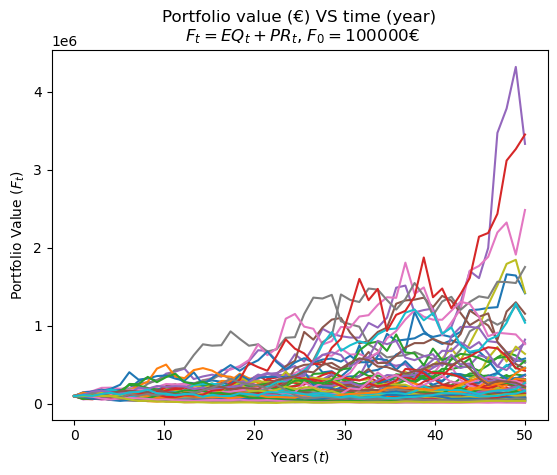

In [ ]:
# Read Excel file
df = pd.read_excel('EIOPA_RFR_20240331_Term_Structures.xlsx', "RFR_spot_no_VA", usecols="C", )
df = df[9:]
df = df.rename(columns={'Unnamed: 18': 'EIOPA EU without VA, MAR'})
rt = np.array(df).T
rt = np.array(rt, np.float64)
rt = rt[0, :N] # Time-varying risk-free rate
# Simulate equity and property paths
EQt = simulate_gbm_vec(F0, rt, sigma_equity, dt, N, z)
PRt = simulate_gbm_vec(F0, rt, sigma_property, dt, N, z)
# Calculate the fund value at each time step
fund_value = EQ_weight * EQt + PR_weight * PRt
F = np.squeeze(fund_value)

# Define time interval correctly
time = np.linspace(0,T,N)
# Require numpy array that is the same shape as F
tt = np.full(shape=(m_MC,N), fill_value=time).T
# Check that the dimensions are OK for the plot
print(str(tt.shape) + str(fund_value.T.shape))

plt.plot(tt, fund_value.T);
plt.xlabel("Years $(t)$")
plt.ylabel("Portfolio Value $(F_t)$")
plt.title("Portfolio value (€) VS time (year)\n $F_t = EQ_t + PR_t$, $F_0 = 100000€$")
plt.show()